In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [49]:
# Load datas
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

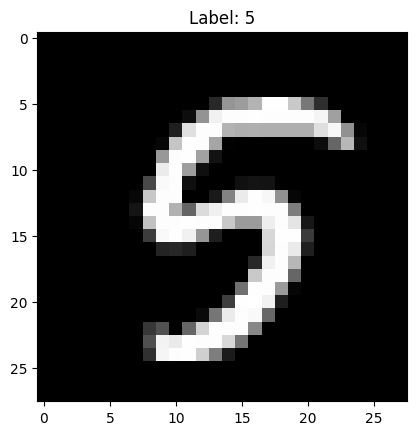

In [50]:
viewDigitIndex = 8
plt.imshow(train_data.iloc[viewDigitIndex, 1:].values.reshape(28, 28), cmap='gray')
plt.title(f"Label: {train_data.iloc[viewDigitIndex, 0]}")
plt.show()

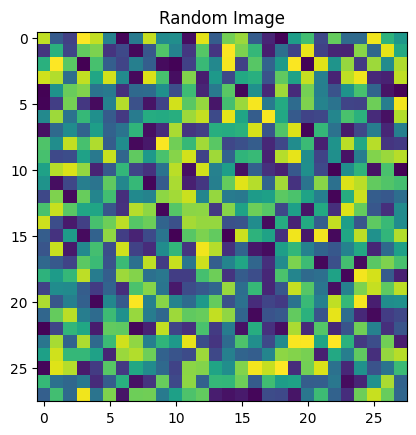

In [51]:
# create a random matrix 28 X 28 
image_data = np.random.rand(28, 28)
# show it as image
# while pass in one signle matrix and choose viridis will be a 'fake' color
plt.imshow(image_data, cmap='viridis')
plt.title("Random Image")
plt.show()

In [62]:
class DigitDataset(Dataset):
    def __init__(self, data, transform=None, has_labels=True):
        self.transform = transform
        self.has_labels = has_labels
        if has_labels:
            # make labels 
            self.labels = data.iloc[:, 0].values
            # -1 means to auto calculate [batch] values 28 x 28 even your data is more than 28 x 28 
            self.images = data.iloc[:, 1:].values.reshape(-1, 28, 28).astype(np.float32)
        else:
            self.labels = None
            self.images = data.values.reshape(-1, 28, 28).astype(np.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        if self.has_labels:
            label = self.labels[idx]
            return image, label
        else:
            return image 

# transform will be use in this example
# 
transform = transforms.Compose([
    # nomalize data ->data range to 0 - 1 | convert to pytorch type (for CUDA and graphic card compte)
    transforms.ToTensor(),
    # check notion for more detaul | in a nutshell this is convert data to N(0,1),  Z
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = DigitDataset(train_data, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [53]:
#  this is a class define a simple CNN [Convolutional Neural Network]
#  means class simpleNN is inhertence| extend from nn.Module
class SimpleCNN(nn.Module):
    # @override? father class _init_ function. 
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # nn.Conv2d is write for picutre task specially
        # prarms: 1) in_channels rgb or grey 1 || 3 | 2) out_channels Means current layer will have 32 outputs
        # 3) kernel_size=3: 'window' how big of the size that windows is looking at a time? 
        # 4) padding 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # 
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [55]:
for epoch in range(10):  # train for ten epoch
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

Epoch 1, Loss: 0.6167149291419151
Epoch 2, Loss: 0.07918964239592909
Epoch 3, Loss: 0.05648705574345053
Epoch 4, Loss: 0.047488438355180226
Epoch 5, Loss: 0.04254326928385071
Epoch 6, Loss: 0.03749561089266003
Epoch 7, Loss: 0.03135329439704603
Epoch 8, Loss: 0.03173748074344545
Epoch 9, Loss: 0.026342268526204974
Epoch 10, Loss: 0.02312812968043967


In [63]:
test_dataset = DigitDataset(test_data, transform=transform, has_labels=False)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

predictions = []
with torch.no_grad():
    for images in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())

In [69]:
#  test out top 100 record from train data to see how its perform generally
# 假设 train_data 是一个 DataFrame，包含训练样本和标签
# 提取前 100 个样本和标签
sample_data = train_data.iloc[:100]
sample_images = sample_data.iloc[:, 1:].values.reshape(-1, 28, 28).astype(np.float32)
sample_labels = sample_data.iloc[:, 0].values

# 创建数据集和数据加载器
sample_dataset = DigitDataset(sample_data, transform=transform, has_labels=True)
sample_loader = DataLoader(sample_dataset, batch_size=10, shuffle=False)

# 生成预测
predictions = []
with torch.no_grad():
    for images, labels in sample_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())

# 计算准确率
correct = sum(p == l for p, l in zip(predictions, sample_labels))
accuracy = correct / len(sample_labels)
print(f"Accuracy on first 100 samples: {accuracy * 100:.2f}%")

Accuracy on first 100 samples: 99.00%


Incorrect sample indices: [95]


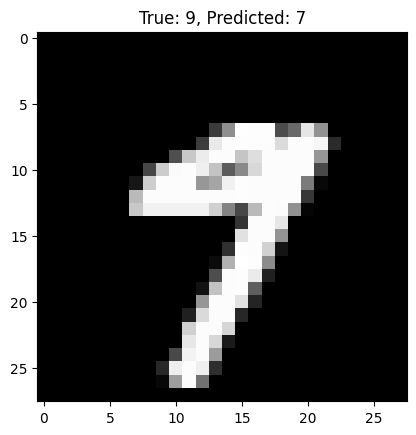

In [72]:
#  check out error images
incorrect_indices = [i for i, (p, l) in enumerate(zip(predictions, sample_labels)) if p != l]
print("Incorrect sample indices:", incorrect_indices)
# 可视化错误样本
for idx in incorrect_indices:
    plt.imshow(sample_images[idx], cmap='gray')
    plt.title(f"True: {sample_labels[idx]}, Predicted: {predictions[idx]}")
    plt.show()

In [ ]:
submission = pd.DataFrame({'ImageId': np.arange(1, len(predictions) + 1), 'Label': predictions})
submission.to_csv('submission.csv', index=False)